In [1]:
import os
# running from Root directory
os.chdir("..")

In [2]:
from motif_search_main import load_network_from_args
from utils.export_import import import_results
from utils.logs import log_motif_criteria_args, log_motif_results, log_sub_graph_args, log_randomizer_args, log_motifs_table
from utils.types import MotifCriteriaArgs, MotifType, MotifName, Motif
import matplotlib.pyplot as plt
import networkx as nx
from typing import Union
import numpy as np
from collections import defaultdict
from isomorphic.isomorphic import get_sub_graph_mapping_to_motif
from post_motif_analysis.network_utils import draw_sub_graph, draw_neighbors, node_properties
from post_motif_analysis.statistics_utils import z_score_bootstrap
from matplotlib.patches import ArrowStyle 
import matplotlib.patches as patches
from networks.network import Network
from numpy import linalg as LA
import plotly.express as px
from tqdm.notebook import trange, tqdm

In [3]:
three_sub_graphs_mapping = {
    14: "mutual out",
    38: "feed forward",
    46: "regulating mutual",
    74: "mutual in",
    78: "bi-mutual",
    102: "mutual cascade",
    108: "regulated mutual",
    110: "semi clique",
    6: "fan out",
    12: "cascade",
    36: "fan in",
    98: "feed backward",
    238: "clique"
}

three_sub_graphs_colors = {
    14: "#1f77b4",
    38: "#ff7f0e",
    46: "#2ca02c",
    74: "#d62728",
    78: "#9467bd",
    102: "#8c564b",
    108: "#e377c2",
    110: "#7f7f7f",
    6: "#bcbd22",
    12: "#17becf",
    36: "red",
    98: "green",
    238: "black"
}

In [4]:
network_groups = [
    # nerve-ring
    [
    'pol_k3_m5_nerve_ring_sf200',
    'cook_si2_herm_chem_k3_m5_nerve_ring_sf200',
    'cook_si2_herm_gap_k3_m5_nerve_ring_sf200',
    'cook_si2_male_chem_k3_m5_nerve_ring_sf200',
    'cook_si2_male_gap_k3_m5_nerve_ring_sf200'
    ],
    # nerve-ring with bio rand
    [
    'pol_k3_m5_nerve_ring_bio_rand_sf200',
    'cook_si2_herm_chem_k3_m5_nerve_ring_bio_rand_sf200',
    'cook_si2_herm_gap_k3_m5_nerve_ring_bio_rand_sf200',
    'cook_si2_male_chem_k3_m5_nerve_ring_bio_rand_sf200',
    'cook_si2_male_gap_k3_m5_nerve_ring_bio_rand_sf200'
    ],
    # all connectome
    [
    'pol_k3_m5_sf200',
    'cook_si2_herm_chem_k3_m5_sf200',
    'cook_si2_herm_gap_k3_m5_sf200',
    'cook_si2_male_chem_k3_m5_sf200',
    'cook_si2_male_gap_k3_m5_sf200',
    # 'durbin_herm_chem_k3_m5',
    ],
    # Monoamines (and with gap or pol alone isnt relevant)
    [
    'pol_k3_m5_sf200',
    'ma_and_cook_si2_herm_chem_sf200',
    'ma_and_cook_si2_male_chem_sf200',
    'pol_m5_OR__ma_AND_cook_si2_herm_chem_sf200',
    'ma_all_sf200',
        
    ],
    # Polarity [+ -]
    [
    'pol_k3_m5_sf200',
    'pol_glu_k3_m5_sf200',
    'pol_gaba_k3_m5_sf200',
    'pol_ach_k3_m5_sf200',        
    ],
    # Complex Polarity [+ - complex]
    [
    'cmpx_pol_k3_m5_sf200',
    'cmpx_pol_glu_k3_m5_sf200',
    'cmpx_pol_gaba_k3_m5_sf200',
    'cmpx_pol_ach_k3_m5_sf200',        
    ],
]

titles = [
    'nerve-ring',
    'nerve-ring w bio-rand', 
    'full connectome',
    'Monoamines',
    'Polarity [+ -]',
    'Complex Polarity [+ - complex]'
]

In [5]:
def draw_graph_on_plot(graph, center_x, center_y, range_x, range_y, factor, ax, edge_color, motif_id):
    node_positions = nx.circular_layout(graph)
    for node in node_positions:
        x = node_positions[node][0]
        y = node_positions[node][1]
        
        new_x = x * range_x/factor + center_x
        new_y = y * range_y/factor + center_y
        node_positions[node] = (new_x, new_y)
        
    node_pos = [node_positions[v] for v in graph.nodes()]
    for node, pos in node_positions.items():
        ax.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')
    
    for u, v in graph.edges():
        ax.annotate("", xy=node_positions[v], xytext=node_positions[u],
                    arrowprops=dict(arrowstyle="->", linewidth=1.5, color=edge_color))
        

    ax.text(pos[0], pos[1]/2, motif_id, fontsize=10, ha='center', va='center') 
    label = three_sub_graphs_mapping[int(motif_id)]
    ax.text(pos[0], pos[1]/3, label, fontsize=6, ha='center', va='center') 

    handles, labels = ax.get_legend_handles_labels()

def draw_graphs(motifs: list[Motif]):
    fig, ax = plt.subplots()
    fig.set_size_inches(13, 3)
    step = 18
    ax.set_ylim(ymin=0, ymax=step)
    ax.set_xlim(xmin=0, xmax=(step+2) * 13)

    range_x = 13 * step
    range_y = 3  * step
    for i, m in enumerate(motifs):
        color = three_sub_graphs_colors[m.id]
        cx = (i+1) * step
        graph = nx.DiGraph(m.role_pattern)
        draw_graph_on_plot(graph, cx, step/2, range_x, range_y, step*1.5, ax, color, m.id)

In [20]:
def discretized_z_scores(z: float):
    thresholds = [4,2]
    for pos_th in thresholds:
        if z >= pos_th:
            return pos_th
    for neg_th in list(np.array(thresholds) * -1):
        if z <= neg_th:
            return neg_th
    return 0

markers = ['*', 'o', '.', '^', 'v', 'p']

def z_score_compare_plot(network_motifs: list[list[Motif]], names: list[str], mode: str, title: str):
    """
    mode: norm - normalize Z score among each network
          disc - discretize Z scores according to |2| and |4| thresholds.
    """
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 3)
    for idx, motifs in enumerate(network_motifs):
        marker = markers[idx % len(markers)]
        triad_motifs = motifs[:13]
        ids = [str(m.id) for m in triad_motifs]
        z_scores = [round(m.motif_criteria.z_score, 2) for m in triad_motifs]
        if mode == 'norm':
            z_scores = np.array(z_scores) / LA.norm(z_scores)
            y_label = 'Normalized'
        elif mode == 'disc':
            z_scores = list(map(discretized_z_scores, z_scores))
            y_label = 'Discretized'
        else:
            print(f'err in mode: {mode}')
            return

        ax.plot(ids, z_scores, marker=marker, ms=6, ls='--', lw=1.5, alpha=0.7, label=names[idx])

    lgd = ax.legend(loc='best', title="network", fontsize=7)
    ax.grid(True)
    plt.ylabel(f'{y_label} Z-score')
    plt.title(f'{title}')
    # fig.savefig(f'{title} - {y_label} Z-scores.svg')

def get_z_upper_rel(z_dist: list):
    return np.percentile(z_dist, 90) - np.mean(z_dist) if z_dist else 0

def get_z_lower_rel(z_dist: list):
    return np.mean(z_dist) - np.percentile(z_dist, 10) if z_dist else 0

def get_z_upper_abs(z_dist: list):
    return np.percentile(z_dist, 90) if z_dist else 0

def get_z_lower_abs(z_dist: list):
    return np.percentile(z_dist, 10) if z_dist else 0


def z_score_dist_compare_errbar_plot(network_motifs: list[list[Motif]],
                                     names: list[str],
                                     z_distributions: list,
                                     title: str,
                                     mode: str):
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 3)

    for idx, (motifs, zz) in enumerate(zip(network_motifs, z_distributions)):
        marker = markers[idx % len(markers)]
        triad_motifs = motifs[:13]
        ids = [str(m.id) for m in triad_motifs]
        
        z_scores_means = np.nan_to_num(np.array([np.mean(z_dist) for z_dist in zz]))
        if mode == 'disc_dist':
            y_label = 'Discretized distribution of'
            z_errs_upper = list(map(get_z_upper_abs, zz))
            z_errs_lower = list(map(get_z_lower_abs, zz))
            
            z_scores_means_disc = list(map(discretized_z_scores, z_scores_means))
            z_errs_upper_disc = list(map(discretized_z_scores, z_errs_upper))
            z_errs_upper_disc = np.array(z_errs_upper_disc)-np.array(z_scores_means_disc)
            
            z_errs_lower_disc = list(map(discretized_z_scores, z_errs_lower))
            z_errs_lower_disc = np.array(z_scores_means_disc)-np.array(z_errs_lower_disc)
            
            z_scores_means = z_scores_means_disc
            z_errs = np.array([z_errs_lower_disc, z_errs_upper_disc])
        elif mode == 'dist':
            y_label = 'Distribution of'
            z_errs_upper = list(map(get_z_upper_rel, zz))
            z_errs_lower = list(map(get_z_lower_rel, zz))
            z_errs = np.array([z_errs_lower, z_errs_upper])
        else:
            print(f'err in mode: {mode}')
            return
        ax.errorbar(ids, z_scores_means, z_errs, ms=8, ls='--', lw=1.2, alpha=0.75, marker=marker, capsize=5, label=names[idx])
        
    lgd = ax.legend(loc='best', title="network", fontsize=7)
    ax.grid(True)
    plt.ylabel(f'{y_label} Z-scores')
    plt.title(f'{title}')
    fig.savefig(f'{title} - {y_label} Z-scores.svg')

In [7]:
# network_groups = [
#     # nerve-ring
#     [
#     'pol_k3_m5_nerve_ring_sf200',
#     'cook_si2_herm_chem_k3_m5_nerve_ring_sf200',
#     ],
#     # nerve-ring with bio rand
#     [
#     'cook_si2_herm_chem_k3_m5_nerve_ring_bio_rand_sf200',
#     ],
# ]

# Load all network bin files
networks_groups_motifs = []
for group in network_groups:
    network_motifs = []
    for name in group:
        data = import_results(f'results/{name}.bin')
        network_motifs.append(list(data['motifs'].values()))
    networks_groups_motifs.append(network_motifs)

def calculate_z_dist():
    networks_groups_motifs_z_dists = []
    for group, network_motifs in zip(network_groups, networks_groups_motifs):
        group_z_dists = []
        for motifs in tqdm(network_motifs):
            triad_motifs = motifs[:13]
            np.random.seed(42)
            group_z_dists.append([z_score_bootstrap(m) for m in tqdm(triad_motifs)])
        networks_groups_motifs_z_dists.append(group_z_dists)
    return networks_groups_motifs_z_dists

def run_all(mode: str):
    if mode in ['norm', 'disc']: 
        for group, network_motifs, title in zip(network_groups,
                                                networks_groups_motifs,
                                                titles):
            z_score_compare_plot(network_motifs, names=group, mode=mode, title=title)
    elif mode in ['dist', 'disc_dist']:
        for group, network_motifs, z_dists, title in zip(network_groups,
                                                         networks_groups_motifs,
                                                         networks_groups_motifs_z_dists,
                                                         titles):
            z_score_dist_compare_errbar_plot(network_motifs, names=group, z_distributions=z_dists, title=title, mode=mode)
            
# networks_groups_motifs_z_dists = calculate_z_dist()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

motif id: 238 err: std was 0, 5000.0 times! z scores len is: 8468


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

motif id: 238 err: std was 0, 5000.0 times! z scores len is: 0


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

motif id: 238 err: std was 0, 5000.0 times! z scores len is: 0


  0%|          | 0/13 [00:00<?, ?it/s]

motif id: 238 err: std was 0, 5000.0 times! z scores len is: 0


  0%|          | 0/13 [00:00<?, ?it/s]

motif id: 110 err: std was 0, 5000.0 times! z scores len is: 0
motif id: 238 err: std was 0, 5000.0 times! z scores len is: 0


  0%|          | 0/13 [00:00<?, ?it/s]

motif id: 238 err: std was 0, 5000.0 times! z scores len is: 0


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

motif id: 238 err: std was 0, 5000.0 times! z scores len is: 0


  0%|          | 0/13 [00:00<?, ?it/s]

motif id: 78 err: std was 0, 5000.0 times! z scores len is: 8614
motif id: 102 err: std was 0, 5000.0 times! z scores len is: 0
motif id: 110 err: std was 0, 5000.0 times! z scores len is: 8690
motif id: 238 err: std was 0, 5000.0 times! z scores len is: 0


  0%|          | 0/13 [00:00<?, ?it/s]

motif id: 74 err: std was 0, 5000.0 times! z scores len is: 0
motif id: 78 err: std was 0, 5000.0 times! z scores len is: 0
motif id: 102 err: std was 0, 5000.0 times! z scores len is: 0
motif id: 108 err: std was 0, 5000.0 times! z scores len is: 0
motif id: 110 err: std was 0, 5000.0 times! z scores len is: 0
motif id: 238 err: std was 0, 5000.0 times! z scores len is: 0


  0%|          | 0/13 [00:00<?, ?it/s]

motif id: 110 err: std was 0, 5000.0 times! z scores len is: 0
motif id: 238 err: std was 0, 5000.0 times! z scores len is: 0


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

motif id: 238 err: std was 0, 5000.0 times! z scores len is: 0


  0%|          | 0/13 [00:00<?, ?it/s]

motif id: 74 err: std was 0, 5000.0 times! z scores len is: 0
motif id: 78 err: std was 0, 5000.0 times! z scores len is: 0
motif id: 98 err: std was 0, 5000.0 times! z scores len is: 0
motif id: 102 err: std was 0, 5000.0 times! z scores len is: 0
motif id: 108 err: std was 0, 5000.0 times! z scores len is: 0
motif id: 110 err: std was 0, 5000.0 times! z scores len is: 0
motif id: 238 err: std was 0, 5000.0 times! z scores len is: 0


  0%|          | 0/13 [00:00<?, ?it/s]

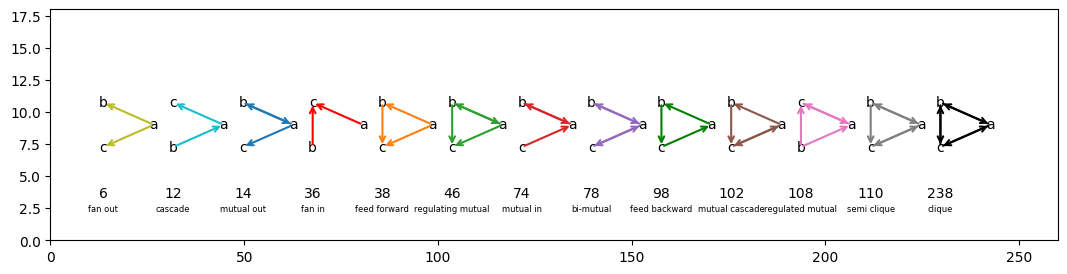

In [13]:
draw_graphs(networks_groups_motifs[0][0])

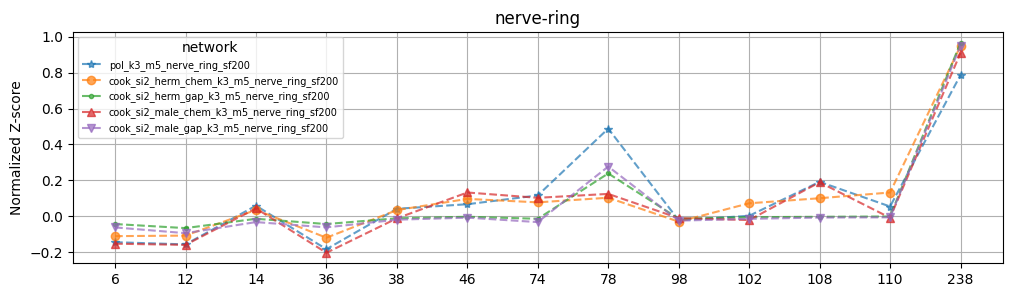

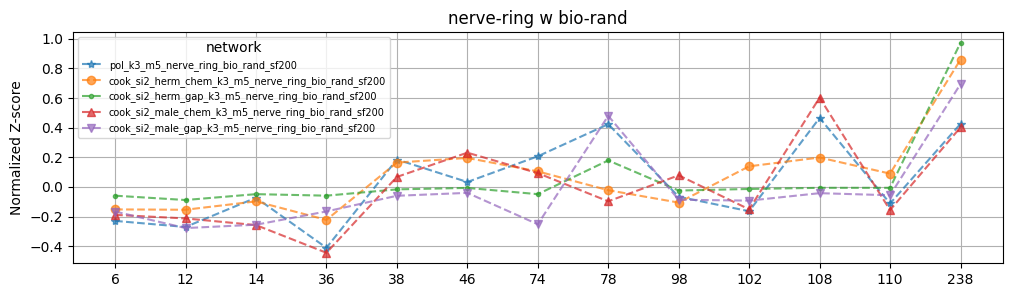

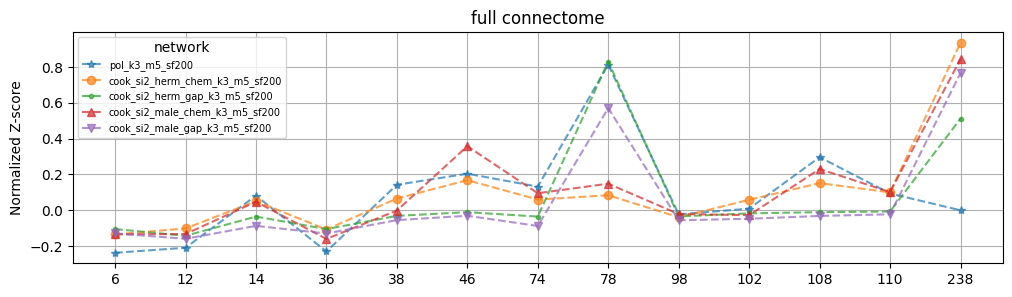

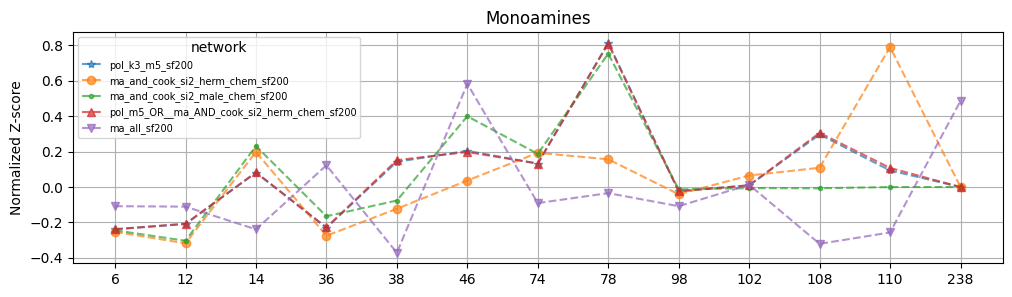

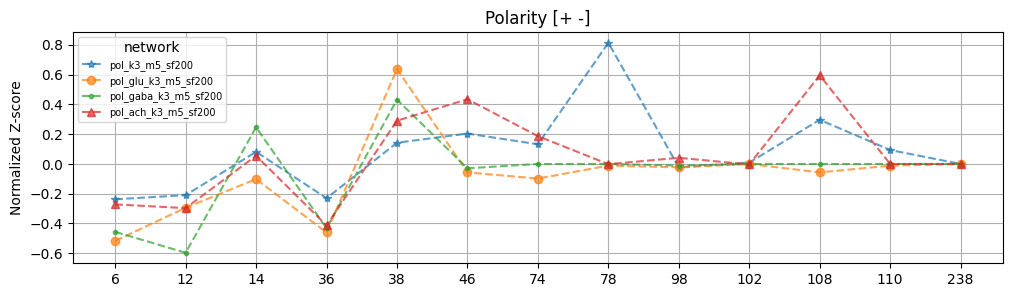

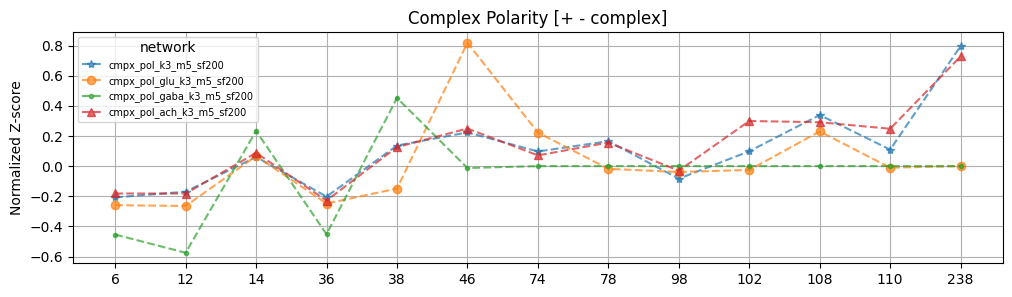

In [9]:
run_all('norm')

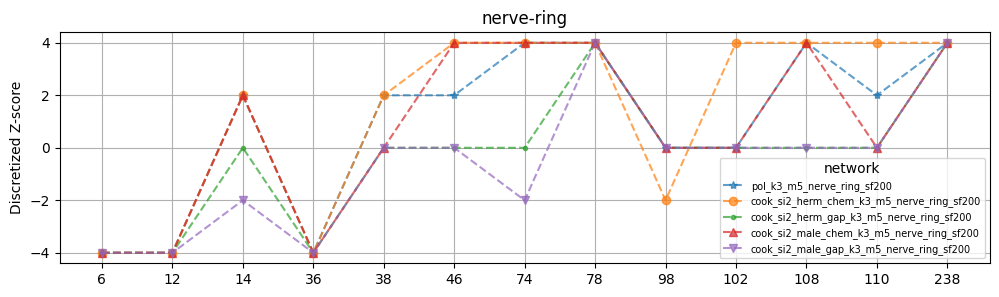

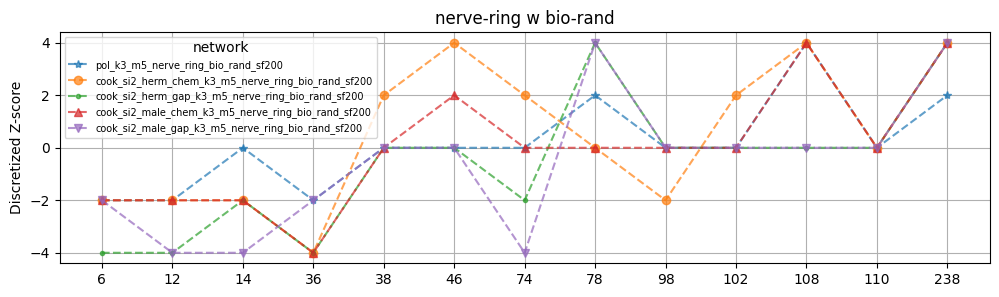

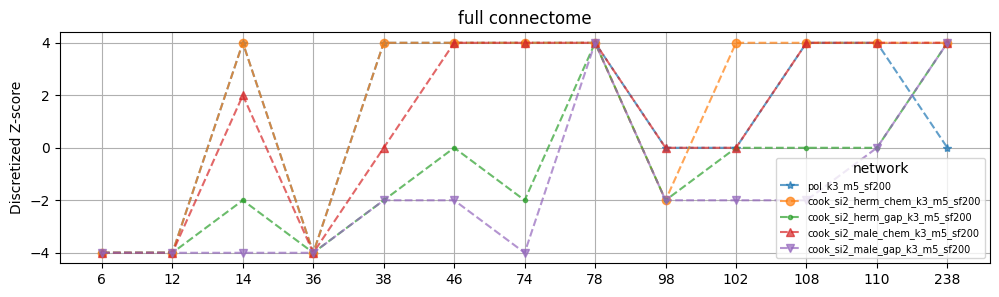

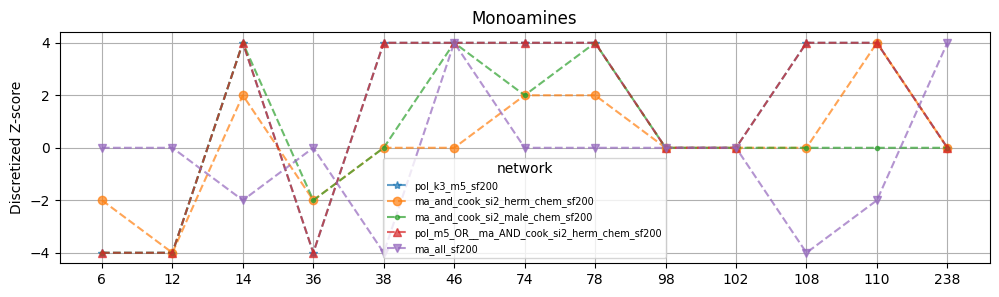

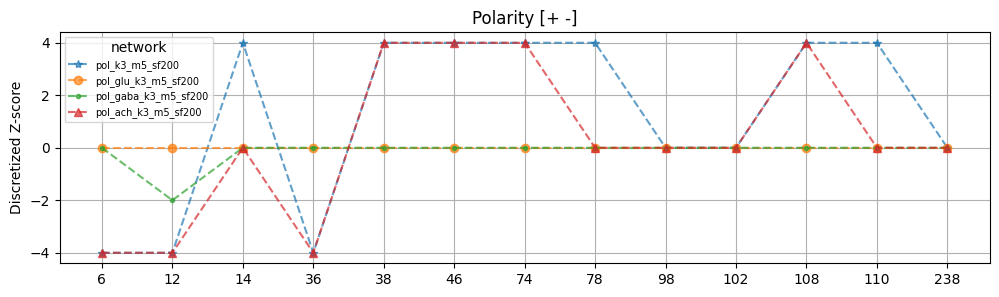

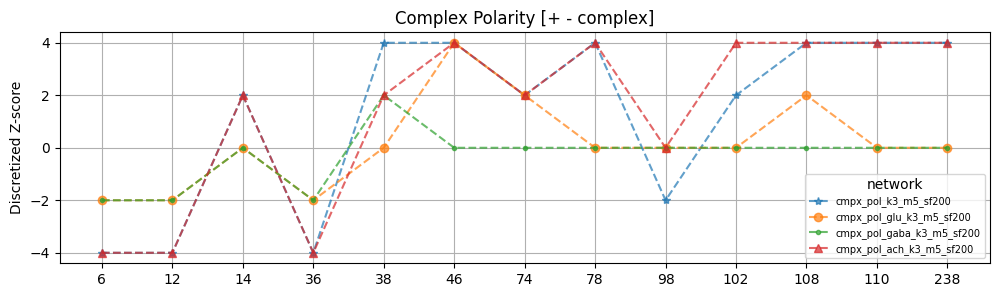

In [10]:
run_all('disc')

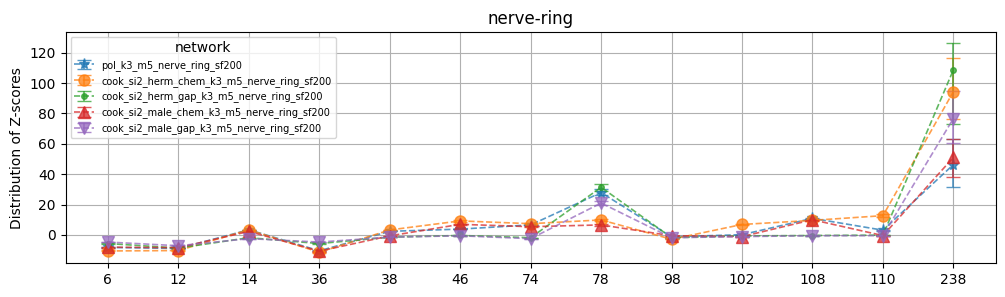

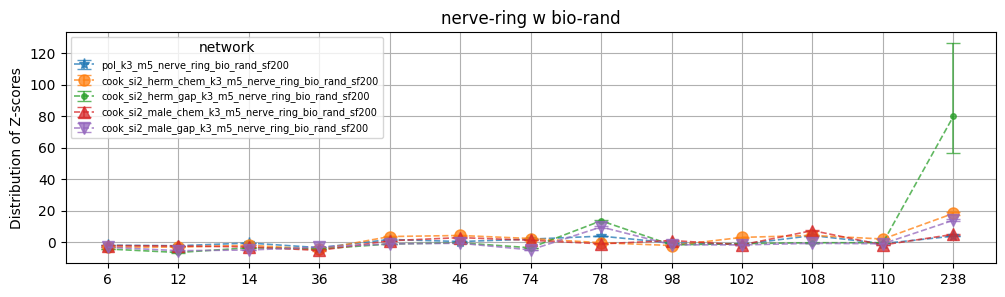

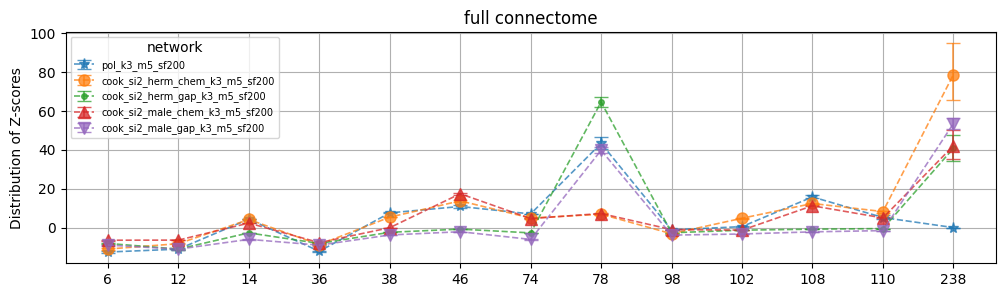

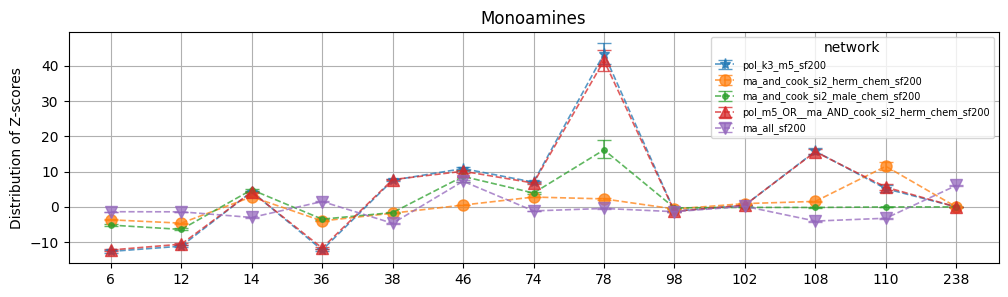

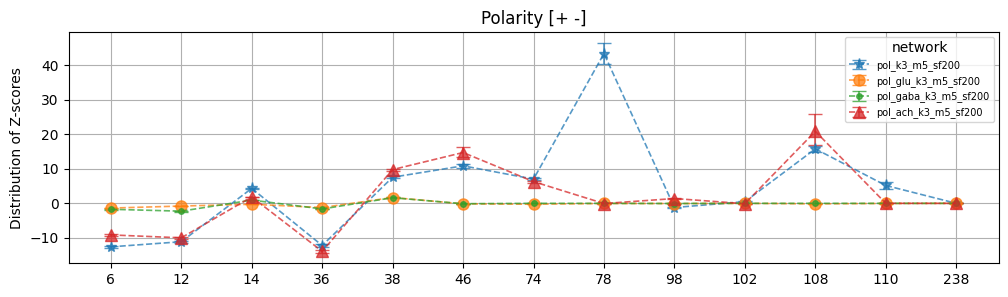

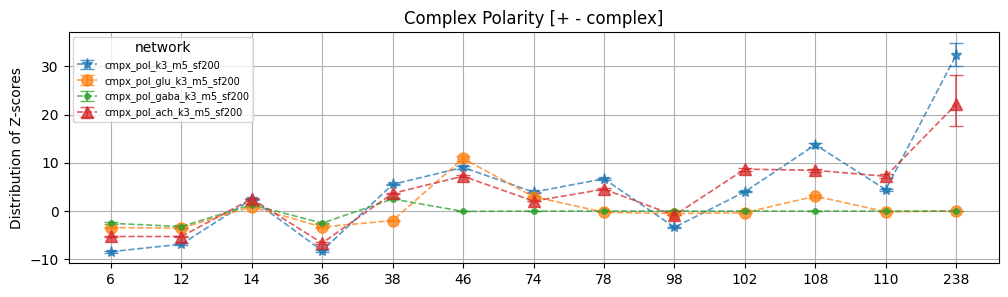

In [23]:
run_all('dist')

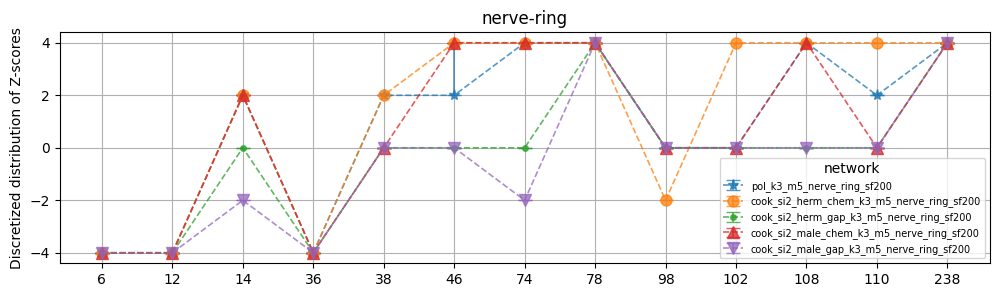

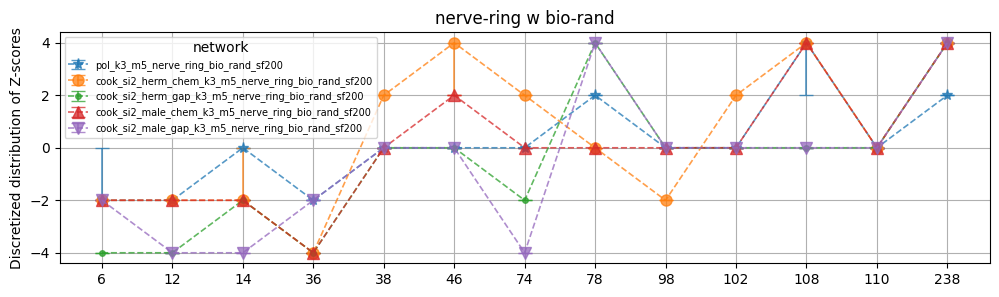

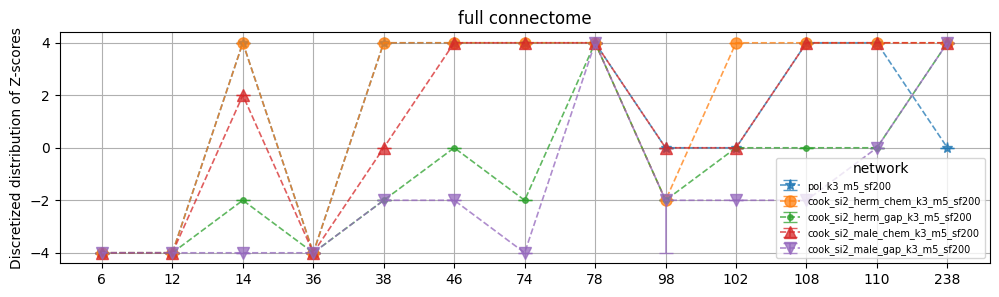

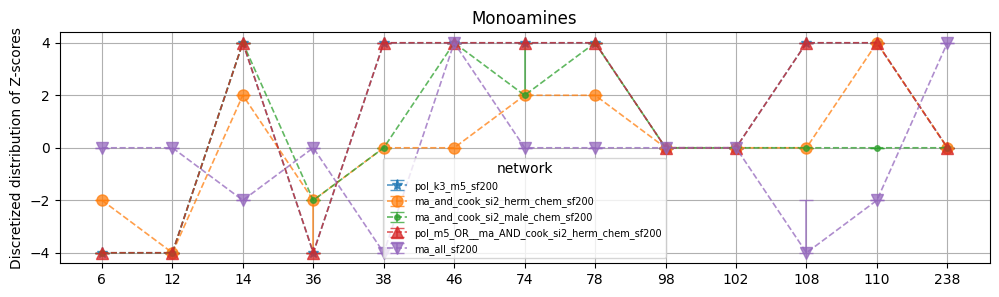

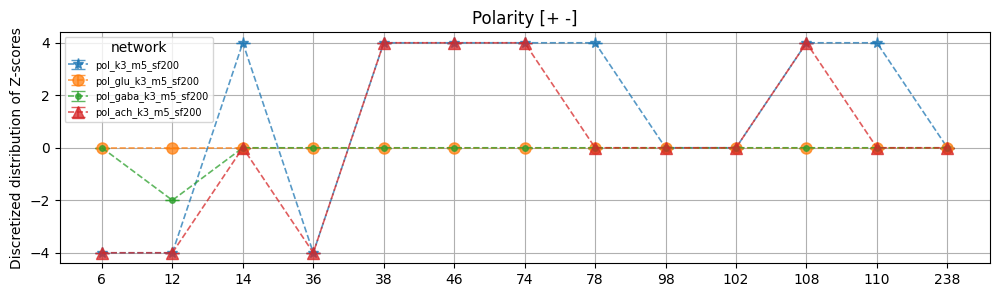

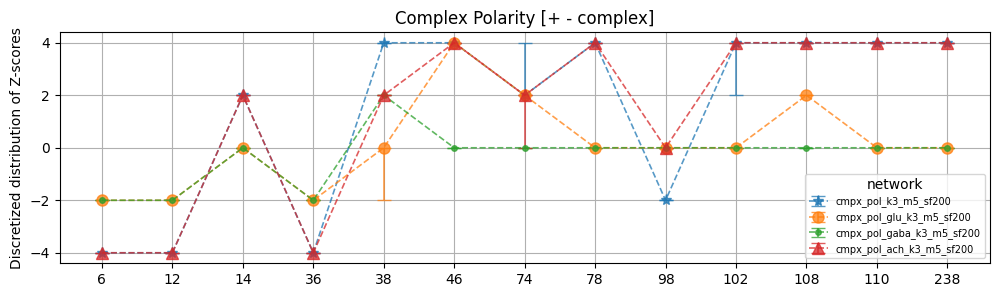

In [21]:
run_all('disc_dist')